In [655]:
import numpy as np
import matplotlib.pyplot as plt
# import seaborn as sns
import statsmodels.api as sm

In [656]:
np.random.poisson(lam=1, size=1000)

array([0, 2, 0, 2, 1, 1, 0, 1, 2, 3, 1, 1, 0, 1, 0, 0, 3, 0, 0, 0, 1, 3,
       1, 1, 1, 0, 0, 0, 3, 0, 2, 0, 1, 1, 0, 1, 1, 1, 2, 0, 1, 1, 1, 1,
       0, 1, 1, 5, 1, 2, 0, 0, 0, 1, 1, 1, 2, 2, 0, 2, 2, 0, 3, 0, 1, 1,
       2, 4, 0, 1, 0, 2, 0, 0, 1, 0, 1, 0, 1, 0, 4, 1, 2, 1, 0, 0, 0, 0,
       2, 1, 1, 0, 0, 0, 0, 3, 1, 0, 2, 1, 0, 3, 1, 0, 1, 2, 0, 1, 1, 1,
       3, 1, 1, 3, 0, 0, 0, 1, 1, 1, 1, 1, 1, 2, 0, 1, 2, 3, 1, 1, 0, 4,
       1, 1, 1, 1, 1, 4, 2, 1, 0, 2, 2, 2, 1, 1, 3, 1, 3, 2, 1, 1, 1, 0,
       1, 2, 0, 1, 0, 0, 1, 1, 0, 2, 2, 1, 1, 2, 1, 1, 0, 2, 1, 0, 2, 0,
       0, 2, 1, 1, 1, 1, 1, 0, 2, 0, 1, 0, 1, 1, 0, 3, 1, 2, 1, 1, 1, 1,
       0, 0, 2, 2, 1, 2, 1, 2, 2, 1, 0, 1, 2, 3, 1, 2, 0, 0, 1, 1, 0, 1,
       0, 2, 2, 1, 1, 0, 0, 1, 0, 1, 2, 2, 1, 1, 3, 3, 1, 0, 0, 0, 1, 1,
       1, 2, 1, 0, 0, 1, 2, 2, 0, 1, 1, 3, 0, 5, 2, 1, 2, 0, 1, 0, 2, 1,
       1, 1, 3, 0, 2, 2, 2, 2, 0, 0, 2, 1, 3, 1, 3, 0, 1, 1, 2, 1, 3, 1,
       0, 1, 0, 1, 5, 2, 1, 0, 0, 0, 1, 2, 0, 0, 1,

In [657]:
# simulate neurons over 8 trials
n_cells = 250
T = 1000 # ms
trials = 8

# random spike pattern (same for all directions)
exp = np.random.randint(2, size=(T, trials, n_cells))

# direction tuned cells



In [658]:
def direction_cosines(v: np.ndarray) -> np.ndarray:
    basis = np.array([[1,0,0], [0,1,0], [0,0,1]])
    normalize = lambda v: v / np.linalg.norm(v)

    cos_x = normalize(v) @ basis[0]
    cos_y = normalize(v) @ basis[1]
    cos_z = normalize(v) @ basis[2]
    
    return np.array([cos_x, cos_y, cos_z])


vertices = [
    (1, 1, 1), 
    (-1, 1, 1), 
    (-1, -1, 1), 
    (1, -1, 1), 
    (1, 1, -1), 
    (-1, 1, -1), 
    (-1, -1, -1), 
    (1, -1, -1)
    ]


B = np.array([direction_cosines(v) for v in vertices])
B

array([[ 0.57735027,  0.57735027,  0.57735027],
       [-0.57735027,  0.57735027,  0.57735027],
       [-0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027, -0.57735027,  0.57735027],
       [ 0.57735027,  0.57735027, -0.57735027],
       [-0.57735027,  0.57735027, -0.57735027],
       [-0.57735027, -0.57735027, -0.57735027],
       [ 0.57735027, -0.57735027, -0.57735027]])

In [659]:
# sanity check
for i in range(len(B)):
    m_x, m_y, m_z = B[i]
    print(np.sqrt((m_x**2 + m_y**2 + m_z**2)), end="  ")

1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [660]:
def compute_direction_vector(neuron: np.ndarray, B: np.ndarray) -> tuple[np.ndarray, bool]:
    # mean firing rate for the 8 trials
    d_M = np.mean(neuron, axis=0)
    
    # fit linear regression
    B_ = sm.add_constant(B)
    model = sm.OLS(d_M, B_).fit()
    predictions = model.predict(B_)
    directional = all(model.pvalues <= 0.05) # True iff all bs below alpha lvl
    
    # extract coefficients (bs)
    b, b_x, b_y, b_z = model.params

    # direction cosines of preferred direction
    k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
    C = np.array([b_x/k, b_y/k, b_z/k])
    
    # vector weight
    d_M_avg = np.mean(d_M) # average firing rate accross trials
    w_M = d_M_avg - b
    
    # wighted direction vector
    N_M = w_M * C
    
    return N_M, directional

In [661]:
vectors = np.zeros((n_cells, 3))
dirs = []
for n in range(n_cells):
    vec, directional = compute_direction_vector(exp[:,:,n], B)
    vectors[n,:] = vec
    dirs.append(directional)

# compute population vector
print(f"Proportion directional: {np.mean(dirs)*100}%")

population_vector = np.sum(vectors, axis=0)
print(f"Population vector: {population_vector}")

print(f"Average cell vector magnitude: {np.mean([np.linalg.norm(v) for v in vectors])}")

Proportion directional: 0.0%
Population vector: [ 1.20449186e-15 -4.49971683e-16  6.71955132e-16]
Average cell vector magnitude: 1.0458300891968974e-16


1.2044918580969058e-15
2.1938274169544032e-16


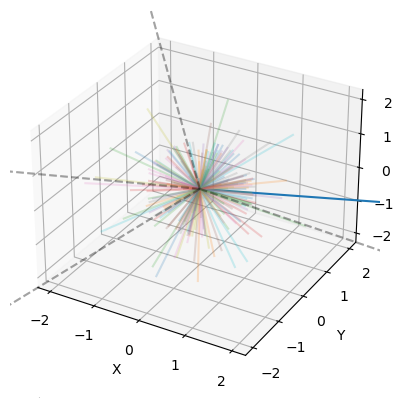

In [662]:
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

def plot_vectors_3d(vectors, mov_axes=False):
    # Plot each vector as a line

    if mov_axes: 
        for v in vectors: ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2, linestyle='--', color='k')
        return

    if vectors.shape == (3,): # single vector
        v = vectors
        ax.plot([0, v[0]], [0, v[1]], [0, v[2]])
        max_dim = max(abs(v[0]), abs(v[1]), abs(v[2]))
    else:
        for v in vectors: ax.plot([0, v[0]], [0, v[1]], [0, v[2]], alpha=0.2)
        max_dim = max(max(abs(v[0]), abs(v[1]), abs(v[2])) for v in vectors)

    # set the limits of the plot
    ax.set_xlim([-max_dim, max_dim])
    ax.set_ylim([-max_dim, max_dim])
    ax.set_zlim([-max_dim, max_dim])
    print(max_dim) # BUG ticks are wrong?

    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')


plot_vectors_3d(population_vector)
plot_vectors_3d(vectors)
plot_vectors_3d(np.array(vertices), mov_axes=True)

### compute angle

In [663]:
def compute_angle(v1: np.ndarray, v2: np.ndarray):
    normalize = lambda v: v / np.linalg.norm(v)
    # v1_u, v2_u = v1, v2
    v1_u, v2_u = normalize(v1), normalize(v2)
    return np.arccos(np.clip((v1_u @ v2_u), -1.0, 1.0))

for vertex in vertices:
    angle = np.degrees(compute_angle(population_vector, vertex))
    print(f"Angle between vertex {vertex} and population vector: {angle}")

Angle between vertex (1, 1, 1) and population vector: 55.41187564713441
Angle between vertex (-1, 1, 1) and population vector: 113.0163775208087
Angle between vertex (-1, -1, 1) and population vector: 91.88291664758437
Angle between vertex (1, -1, 1) and population vector: 22.209159030628044
Angle between vertex (1, 1, -1) and population vector: 88.11708335241563
Angle between vertex (-1, 1, -1) and population vector: 157.79084096937197
Angle between vertex (-1, -1, -1) and population vector: 124.58812435286559
Angle between vertex (1, -1, -1) and population vector: 66.9836224791913


In [664]:
n0 = exp[0]
d_M = np.mean(n0, axis=1)
d_M

array([0.48 , 0.516, 0.516, 0.476, 0.464, 0.484, 0.532, 0.552])

In [665]:
B_ = sm.add_constant(B)
model = sm.OLS(d_M, B_).fit()
predictions = model.predict(B_) 
 
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.468
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     1.172
Date:                Tue, 09 May 2023   Prob (F-statistic):              0.425
Time:                        17:50:28   Log-Likelihood:                 19.500
No. Observations:                   8   AIC:                            -31.00
Df Residuals:                       4   BIC:                            -30.68
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.5025      0.011     47.535      0.0

/opt/miniconda3/envs/fmri/lib/python3.10/site-packages/scipy/stats/_stats_py.py:1736: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=8
  warnings.warn("kurtosistest only valid for n>=20 ... continuing "


In [666]:
b_0, b_x, b_y, b_z = model.params

k = np.sqrt(b_x**2 + b_y**2 + b_z**2)
k

0.03432564638866996

In [667]:
# direction cosines of preferred direction
C = np.array([b_x/k, b_y/k, b_z/k])
C

array([-0.4793641 , -0.83257976, -0.27752659])

In [668]:
w_M = d_M[0] - b_0
w_M * C

array([0.01078569, 0.01873304, 0.00624435])